# ☔️ Claims. Exploratory Data Analysis

## ✍️ Task Description 

**☝️ Background**

**Objective:**
Perform exploratory data analysis (EDA) on a dataset containing insurance claims. Present trends, anomalies, and forecasts to business users in an accessible format.

**Business Context:**
Insurance companies regularly process claims, claims are expenses they pay for medical services rendered to insured patients. Understanding historical claim trends and anticipating future costs is critical for budgeting, pricing, and risk management.

**Goals:**
- Identify key trends in claims data
- Detect anomalies or unusual patterns
- Forecast total claims for the next 6 months
- Deliver insights in a format suitable for business stakeholders

**💿 Data Description**

**This dataset contains aggregated insurance claims data covering the period from January 2018 to July 2020. All figures are fictional and anonymized.**

**📄 Columns:**
- MONTH – Month when claims were lodged (format: YYYY-MM)
- SERVICE_CATEGORY – Department or unit that provided the medical service
- CLAIM_SPECIALTY – Medical service classification (e.g. Cardiology, Radiology)
- PAYER – Insurance company responsible for the claim
- PAID_AMOUNT – Total amount paid by the insurance company for the claims (in USD)

**✈️ Research Plan**

1. Load and preprocess the data
2. Define key business questions
3. Perform exploratory data analysis (EDA)
4. Build metrics and visual reports
5. Answer business questions with insights
6. Prepare final deliverables and forecasts

## 💻 Preprocessing

In [47]:
# libraries 
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import sqlite3
import requests

import warnings
warnings.filterwarnings("ignore")

In [48]:
# csv file
path = 'claims_sample_data.csv'
df = pd.read_csv(path)

In [49]:
df.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937
3,201801,AncillaryFFS,NaN,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [51]:
# low case columns names
new_df_cols = [i.lower() for i in df.columns]
df.columns = new_df_cols

In [52]:
# Convert to string for consistent slicing

df['new_month_str'] = df['month'].astype(str)

# Define valid month range (01–12)
valid_months = [f"{i:02d}" for i in range(1, 13)]

# Split into valid and invalid rows
df['mm'] = df['new_month_str'].str[4:6]
df_valid = df[df['mm'].isin(valid_months)].copy()
df_invalid = df[~df['mm'].isin(valid_months)].copy()

In [53]:
# invalid rows with month 00
df_invalid

,month,service_category,claim_specialty,payer,paid_amount,new_month_str,mm
20778,201900,AncillaryFFS,HOME HEALTH CENTER,Payer H,-124,201900,00
20779,201900,AncillaryFFS,MEDICAL DOCTOR,Payer H,1568,201900,00
20780,201900,AncillaryFFS,PHYSICAL THERAPIST,Payer H,90,201900,00
20781,201900,AncillaryFFS,PHYSICIAN ASSISTANT,Payer H,84,201900,00
20782,201900,AncillaryFFS,SKILLED NURSING FAC,Payer H,-32,201900,00
20783,201900,AncillaryFFS,SPECIAL SERVICES,Payer H,-1956,201900,00
20784,201900,ERServices,HOSPITAL,Payer H,-3050,201900,00
20785,201900,InpatientServices,HOSPITAL,Payer H,-6150,201900,00
20786,201900,InpatientServices,MEDICAL DOCTOR,Payer H,75,201900,00
20787,201900,OutpatientServices,HOSPITAL,Payer H,-17235,201900,00


In [54]:
df = df[df['mm'].isin(valid_months)].copy()

In [55]:
# change month type
df['month'] = pd.to_datetime(df['month'], format='%Y%m', errors = 'coerce')

In [59]:
# dates range
df['month'].min(), df['month'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))

In [60]:
# observe dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52141 entries, 0 to 52151
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   month             52141 non-null  datetime64[ns]
 1   service_category  52141 non-null  object        
 2   claim_specialty   51890 non-null  object        
 3   payer             52141 non-null  object        
 4   paid_amount       52141 non-null  int64         
 5   new_month_str     52141 non-null  object        
 6   mm                52141 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.2+ MB


In [61]:
# also add flag positive, zero or negative amount
df['paid_mark'] = df['paid_amount'].apply(lambda x: 'lower_zero' if x < 0 else 'zero' if x == 0 else 'bigger_zero')

In [62]:
# do we have zero payments?
df['paid_mark'].value_counts()

paid_mark
bigger_zero    47976
zero            3847
lower_zero       318
Name: count, dtype: int64

In [63]:
# check claim_specialty col with Null values
no_speciality_df = df[df['claim_specialty'].isna()]
no_speciality_df.shape

(251, 8)

In [64]:
# sum with no speciality
no_speciality_df['paid_amount'].sum()

704475

In [65]:
# sum with no speciality with payer breakdown
no_speciality_df.groupby('payer').paid_amount.sum()

payer
Payer F    453443
Payer H     66612
Payer O    158349
Payer S     25803
Payer W       268
Name: paid_amount, dtype: int64

In [66]:
# replace Null values with specific one Not Found
df['claim_specialty'] = df['claim_specialty'].fillna('Not Found')

In [67]:
# check duplicates 
df[df.duplicated()].shape[0]

0

In [68]:
# amount of claim_specialty
len(df['claim_specialty'].unique())

906

In [69]:
df.head()

,month,service_category,claim_specialty,payer,paid_amount,new_month_str,mm,paid_mark
0,2018-01-01,AncillaryFFS,Not Found,Payer F,4281,201801,01,bigger_zero
1,2018-01-01,AncillaryFFS,Not Found,Payer H,2221,201801,01,bigger_zero
2,2018-01-01,AncillaryFFS,Not Found,Payer O,3937,201801,01,bigger_zero
3,2018-01-01,AncillaryFFS,Not Found,Payer W,268,201801,01,bigger_zero
4,2018-01-01,AncillaryFFS,ACH,Payer W,151,201801,01,bigger_zero


**🛠️ Preprocessing Summary**
- Renamed columns for consistency and clarity
- Converted MONTH column to datetime type
- Filled missing values in the PAYER column
- Checked and handled duplicate records

## 🔍 EDA

**Key Questions to Explore:**
- Why do negative or zero payments appear in the data?
- Who are the top 10 payers, service categories, and claim specialties by paid amount?
- Is there any seasonality or recurring patterns in claim payments?
- What are the average paid amounts overall, and segmented by payer, category, and specialty?
- Based on trends, what forecasts and business recommendations can we provide?

**Negative and zero payments**

In [70]:
# CATEGORY: amount of the claims with paid mark breakdown COUNT
df_cat_extended = (df.pivot_table(index = 'service_category', 
                                 columns = 'paid_mark', 
                                 values = 'paid_amount', 
                                 aggfunc = 'count')
                                .reset_index()
                   .fillna(0)
                  )

df_cat_extended['zero_ratio'] = round(df_cat_extended['zero'] / (df_cat_extended['bigger_zero'] + df_cat_extended['lower_zero'] + df_cat_extended['zero']) * 100,2)
df_cat_extended['below_zero_ratio'] = round(df_cat_extended['lower_zero'] / (df_cat_extended['bigger_zero'] + df_cat_extended['lower_zero'] + df_cat_extended['zero']) * 100,2)

df_cat_extended

paid_mark,service_category,bigger_zero,lower_zero,zero,zero_ratio,below_zero_ratio
0,ASCServices,2560.0,0.0,83.0,3.14,0.00
1,AncillaryFFS,8153.0,236.0,1306.0,13.47,2.43
2,ERServices,3513.0,0.0,182.0,4.93,0.00
3,InpatientServices,9212.0,0.0,210.0,2.23,0.00
4,OutpatientServices,7323.0,0.0,258.0,3.40,0.00
5,PCPEncounter,43.0,82.0,1097.0,89.77,6.71
6,PCPFFS,1398.0,0.0,5.0,0.36,0.00
7,SNFServices,2366.0,0.0,134.0,5.36,0.00
8,SpecialistFFS,1623.0,0.0,61.0,3.62,0.00
9,SpecialistsFFS,11785.0,0.0,511.0,4.16,0.00


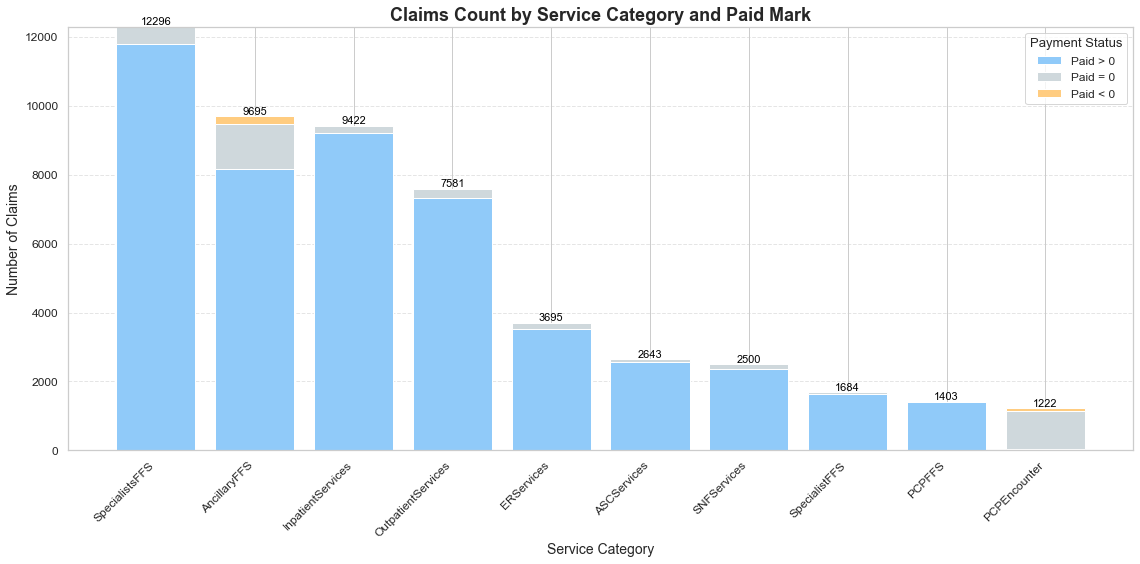

In [71]:
# Clean style
sns.set_style("whitegrid")

# Prepare data
df_cat_extended['total'] = df_cat_extended[['bigger_zero', 'zero', 'lower_zero']].sum(axis=1)
df_cat_extended_sorted = df_cat_extended.sort_values('total', ascending=False)

# Calm muted colors
colors = {
    'bigger_zero': '#90caf9',  # Soft blue
    'zero': '#cfd8dc',         # Light grey
    'lower_zero': '#ffcc80'    # Soft orange
}

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Plot bars
bars1 = ax.bar(df_cat_extended_sorted['service_category'], df_cat_extended_sorted['bigger_zero'],
               label='Paid > 0', color=colors['bigger_zero'])

bars2 = ax.bar(df_cat_extended_sorted['service_category'], df_cat_extended_sorted['zero'],
               bottom=df_cat_extended_sorted['bigger_zero'], label='Paid = 0', color=colors['zero'])

bars3 = ax.bar(df_cat_extended_sorted['service_category'], df_cat_extended_sorted['lower_zero'],
               bottom=df_cat_extended_sorted['bigger_zero'] + df_cat_extended_sorted['zero'],
               label='Paid < 0', color=colors['lower_zero'])

# Labels
ax.set_title('Claims Count by Service Category and Paid Mark', fontsize=18, fontweight='bold')
ax.set_ylabel('Number of Claims', fontsize=14)
ax.set_xlabel('Service Category', fontsize=14)
ax.set_xticks(range(len(df_cat_extended_sorted)))
ax.set_xticklabels(df_cat_extended_sorted['service_category'], rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Value labels on top
for i, total in enumerate(df_cat_extended_sorted['total']):
    ax.text(i, total + 5, f"{int(round(total, 0))}", ha='center', va='bottom', fontsize=11, color='black')

# Legend
ax.legend(title='Payment Status', fontsize=12, title_fontsize=13, loc='upper right')

# Subtle gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

# Layout
plt.tight_layout()
plt.show()


In [72]:
# CATEGORY: amount of the claims with paid mark breakdown SUM
df_cat_extended2 = (df.pivot_table(index = 'service_category', 
                                  columns = 'paid_mark', 
                                  values = 'paid_amount', 
                                  aggfunc = 'sum')
                                .reset_index()
                   )
df_cat_extended2

paid_mark,service_category,bigger_zero,lower_zero,zero
0,ASCServices,5192434.0,NaN,0.0
1,AncillaryFFS,19499693.0,-287091.0,0.0
2,ERServices,11773165.0,NaN,0.0
3,InpatientServices,87861676.0,NaN,0.0
4,OutpatientServices,22935845.0,NaN,0.0
5,PCPEncounter,18353.0,-54241.0,0.0
6,PCPFFS,3897810.0,NaN,0.0
7,SNFServices,8226348.0,NaN,0.0
8,SpecialistFFS,2005359.0,NaN,0.0
9,SpecialistsFFS,32373940.0,NaN,0.0


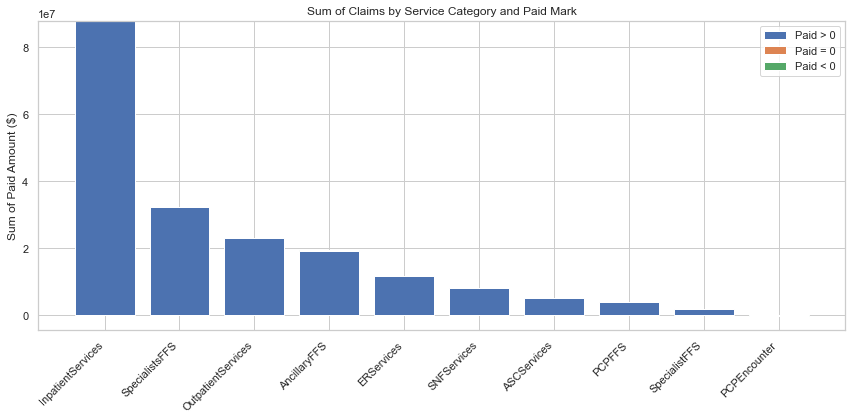

In [73]:
df_cat_extended2_sorted = df_cat_extended2.sort_values(by=['bigger_zero', 'zero', 'lower_zero'], ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_cat_extended2_sorted['service_category'], df_cat_extended2_sorted['bigger_zero'], label='Paid > 0')
plt.bar(df_cat_extended2_sorted['service_category'], df_cat_extended2_sorted['zero'], 
        bottom=df_cat_extended2_sorted['bigger_zero'], label='Paid = 0')
plt.bar(df_cat_extended2_sorted['service_category'], df_cat_extended2_sorted['lower_zero'], 
        bottom=df_cat_extended2_sorted['bigger_zero'] + df_cat_extended2_sorted['zero'], label='Paid < 0')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Sum of Paid Amount ($)')
plt.title('Sum of Claims by Service Category and Paid Mark')
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
# PAYER: amount of the claims with paid mark breakdown COUNT
df_cat_payer = (df.pivot_table(index = 'payer', 
                                 columns = 'paid_mark', 
                                 values = 'paid_amount', 
                                 aggfunc = 'count')
                                .reset_index()
                   .fillna(0)
                  )

df_cat_payer['zero_ratio'] = round(df_cat_payer['zero'] / (df_cat_payer['bigger_zero'] + df_cat_payer['lower_zero'] + df_cat_payer['zero']) * 100,2)
df_cat_payer['below_zero_ratio'] = round(df_cat_payer['lower_zero'] / (df_cat_payer['bigger_zero'] + df_cat_payer['lower_zero'] + df_cat_payer['zero']) * 100,2)

df_cat_payer

paid_mark,payer,bigger_zero,lower_zero,zero,zero_ratio,below_zero_ratio
0,Payer B,3206.0,6.0,419.0,11.54,0.17
1,Payer CA,7851.0,83.0,747.0,8.60,0.96
2,Payer CO,3673.0,1.0,3.0,0.08,0.03
3,Payer F,8878.0,0.0,142.0,1.57,0.00
4,Payer H,2239.0,3.0,107.0,4.56,0.13
5,Payer O,6160.0,0.0,118.0,1.88,0.00
6,Payer S,3913.0,0.0,276.0,6.59,0.00
7,Payer UL,562.0,0.0,123.0,17.96,0.00
8,Payer UN,4898.0,223.0,1405.0,21.53,3.42
9,Payer W,6596.0,2.0,507.0,7.14,0.03


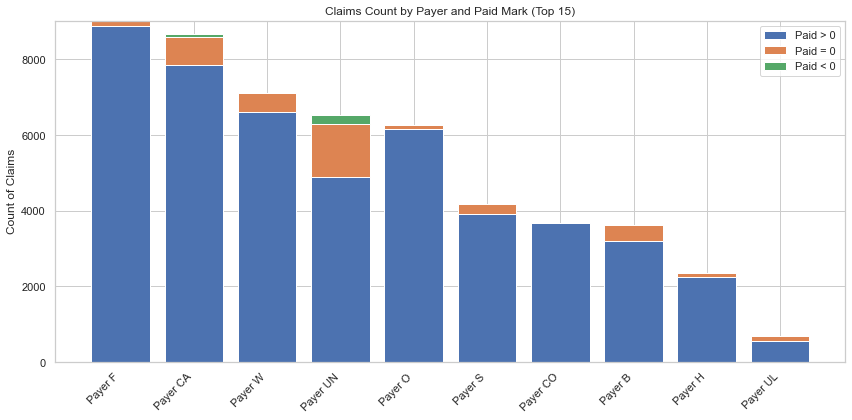

In [75]:
df_cat_payer['total'] = df_cat_payer[['bigger_zero', 'zero', 'lower_zero']].sum(axis=1)
df_cat_payer_sorted = df_cat_payer.sort_values('total', ascending=False).head(15)  # Top 15 payers for clarity

plt.figure(figsize=(12, 6))
plt.bar(df_cat_payer_sorted['payer'], df_cat_payer_sorted['bigger_zero'], label='Paid > 0')
plt.bar(df_cat_payer_sorted['payer'], df_cat_payer_sorted['zero'], bottom=df_cat_payer_sorted['bigger_zero'], label='Paid = 0')
plt.bar(df_cat_payer_sorted['payer'], df_cat_payer_sorted['lower_zero'], 
        bottom=df_cat_payer_sorted['bigger_zero'] + df_cat_payer_sorted['zero'], label='Paid < 0')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Count of Claims')
plt.title('Claims Count by Payer and Paid Mark (Top 15)')
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
# PAYER: amount of the claims with paid mark breakdown SUM
df_cat_payer_sum = (df.pivot_table(index = 'payer', 
                                  columns = 'paid_mark', 
                                  values = 'paid_amount', 
                                  aggfunc = 'sum')
                                .reset_index().fillna(0)
                   )
df_cat_payer_sum

paid_mark,payer,bigger_zero,lower_zero,zero
0,Payer B,2409074.0,-1565.0,0.0
1,Payer CA,33690508.0,-55065.0,0.0
2,Payer CO,5068766.0,-103.0,0.0
3,Payer F,86787408.0,0.0,0.0
4,Payer H,21835415.0,-718.0,0.0
5,Payer O,21419407.0,0.0,0.0
6,Payer S,3810748.0,0.0,0.0
7,Payer UL,310027.0,0.0,0.0
8,Payer UN,6272206.0,-283771.0,0.0
9,Payer W,12181064.0,-110.0,0.0


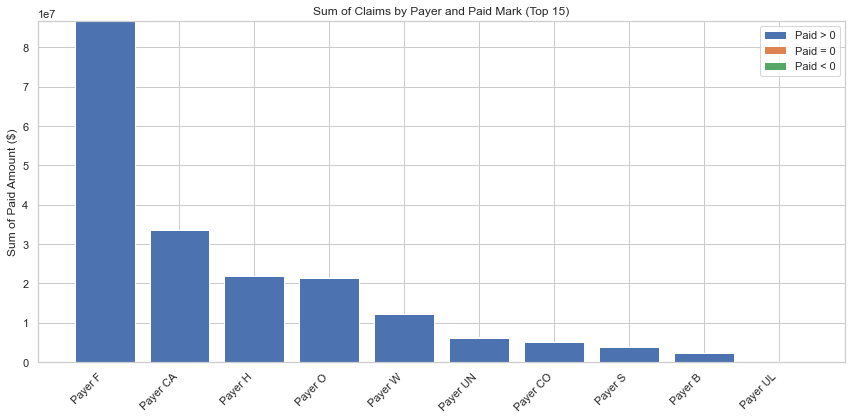

In [77]:
df_cat_payer_sum_sorted = df_cat_payer_sum.sort_values(by=['bigger_zero', 'zero', 'lower_zero'], ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.bar(df_cat_payer_sum_sorted['payer'], df_cat_payer_sum_sorted['bigger_zero'], label='Paid > 0')
plt.bar(df_cat_payer_sum_sorted['payer'], df_cat_payer_sum_sorted['zero'], 
        bottom=df_cat_payer_sum_sorted['bigger_zero'], label='Paid = 0')
plt.bar(df_cat_payer_sum_sorted['payer'], df_cat_payer_sum_sorted['lower_zero'], 
        bottom=df_cat_payer_sum_sorted['bigger_zero'] + df_cat_payer_sum_sorted['zero'], label='Paid < 0')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Sum of Paid Amount ($)')
plt.title('Sum of Claims by Payer and Paid Mark (Top 15)')
plt.legend()
plt.tight_layout()
plt.show()


**negative values**

In [78]:
df[df['paid_mark'] == 'lower_zero']['payer'].unique()

array(['Payer UN', 'Payer B', 'Payer CA', 'Payer H', 'Payer W',
       'Payer CO'], dtype=object)

**Observations on Service Categories**
- The AncillaryFFS category has 236 claims, which represent 2.4% of the total number of claims in that category, with a total amount of -287,091 USD (negative payments).
- The PCPEncounter category has 82 claims, making up 3.5% of its total claims count, with a total amount of -54,241 USD (negative payments).


**zero values**

In [79]:
df[df['paid_mark'] == 'zero']['payer'].unique()

array(['Payer UN', 'Payer B', 'Payer CA', 'Payer S', 'Payer F', 'Payer W',
       'Payer O', 'Payer H', 'Payer CO', 'Payer UL'], dtype=object)

In [80]:
df_cat_extended = df_cat_extended.fillna(0)
df_cat_extended['zero_ratio'] = round(df_cat_extended['zero'] / (df_cat_extended['bigger_zero'] + df_cat_extended['lower_zero'] + df_cat_extended['zero']) * 100,2)
df_cat_extended[['service_category', 'zero_ratio']].sort_values(by = 'zero_ratio')

paid_mark,service_category,zero_ratio
6,PCPFFS,0.36
3,InpatientServices,2.23
0,ASCServices,3.14
4,OutpatientServices,3.40
8,SpecialistFFS,3.62
9,SpecialistsFFS,4.16
2,ERServices,4.93
7,SNFServices,5.36
1,AncillaryFFS,13.47
5,PCPEncounter,89.77


**Observation: Zero-Dollar Payments Across Categories**
We observe that every service category has some claims with $0 payments. This raises important questions about the nature of these claims:

- Could these zero payments represent returned or reversed services?
- Are they possibly disapproved or rejected claims?
- Further investigation is needed (TBD) to clarify the business context and implications of these zero-dollar claims.

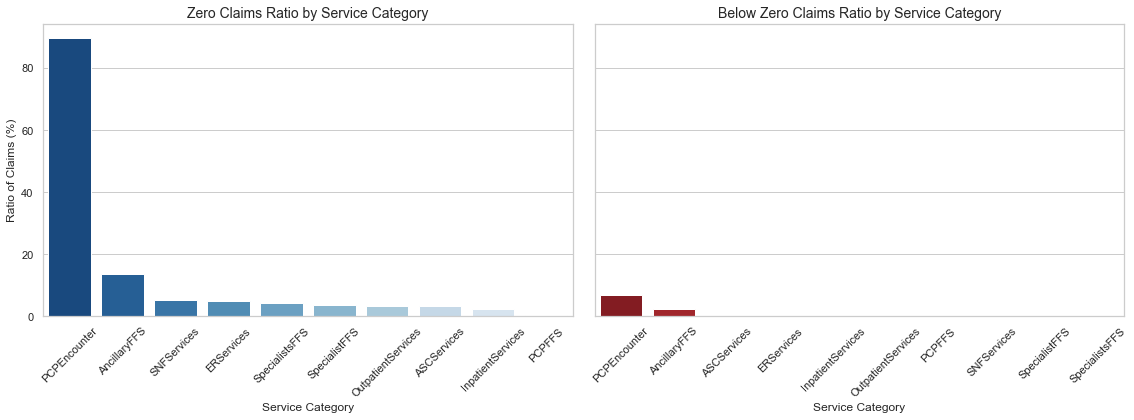

In [81]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# First chart: Zero Claims Ratio
sns.barplot(
    x='service_category', y='zero_ratio', data=df_cat_extended.sort_values('zero_ratio', ascending=False),
    palette='Blues_r', ax=axes[0]
)
axes[0].set_title('Zero Claims Ratio by Service Category', fontsize=14)
axes[0].set_xlabel('Service Category')
axes[0].set_ylabel('Ratio of Claims (%)')
axes[0].tick_params(axis='x', rotation=45)

# Second chart: Below Zero Claims Ratio
sns.barplot(
    x='service_category', y='below_zero_ratio', data=df_cat_extended.sort_values('below_zero_ratio', ascending=False),
    palette='Reds_r', ax=axes[1]
)
axes[1].set_title('Below Zero Claims Ratio by Service Category', fontsize=14)
axes[1].set_xlabel('Service Category')
axes[1].set_ylabel('')  # No ylabel to avoid redundancy
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 🔝 TOP 10

In [82]:
# amount of the claims with paid mark breakdown SUM
df_cat = (df.pivot_table(index = 'service_category', 
                                  values = 'paid_amount', 
                                  aggfunc = 'sum')
                                .reset_index()
                                  .rename(columns={"paid_amount":"total_paid"})
                   )
df_cat

,service_category,total_paid
0,ASCServices,5192434
1,AncillaryFFS,19212602
2,ERServices,11773165
3,InpatientServices,87861676
4,OutpatientServices,22935845
5,PCPEncounter,-35888
6,PCPFFS,3897810
7,SNFServices,8226348
8,SpecialistFFS,2005359
9,SpecialistsFFS,32373940


**Build chart with TOP 10 Service Categories**

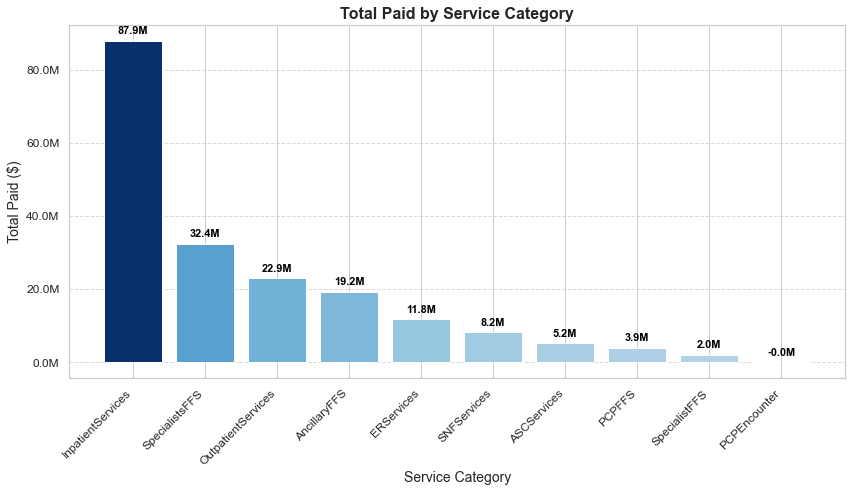

In [83]:
import matplotlib.ticker as mtick

# Sort the DataFrame
df_cat = df_cat.sort_values('total_paid', ascending=False)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

norm = plt.Normalize(df_cat['total_paid'].min(), df_cat['total_paid'].max())
cmap = plt.cm.Blues
colors = cmap(norm(df_cat['total_paid']) * 0.7 + 0.3)

bars = ax.bar(df_cat['service_category'], df_cat['total_paid'], color=colors)

ax.set_xlabel('Service Category', fontsize=14)
ax.set_ylabel('Total Paid ($)', fontsize=14)
ax.set_title('Total Paid by Service Category', fontsize=16, weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Format y-axis ticks in millions with "M"
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))

# Data labels with rounded millions
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height/1e6:.1f}M',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

plt.tight_layout()
plt.show()


**Build chart with TOP 10 Payer**

In [84]:
df_payers = df.groupby('payer')['paid_amount'].sum().reset_index()
df_payers = df_payers.rename(columns = {"paid_amount":"total_paid"}).sort_values(by = 'total_paid', ascending = False)
df_payers

,payer,total_paid
3,Payer F,86787408
1,Payer CA,33635443
4,Payer H,21834697
5,Payer O,21419407
9,Payer W,12180954
8,Payer UN,5988435
2,Payer CO,5068663
6,Payer S,3810748
0,Payer B,2407509
7,Payer UL,310027


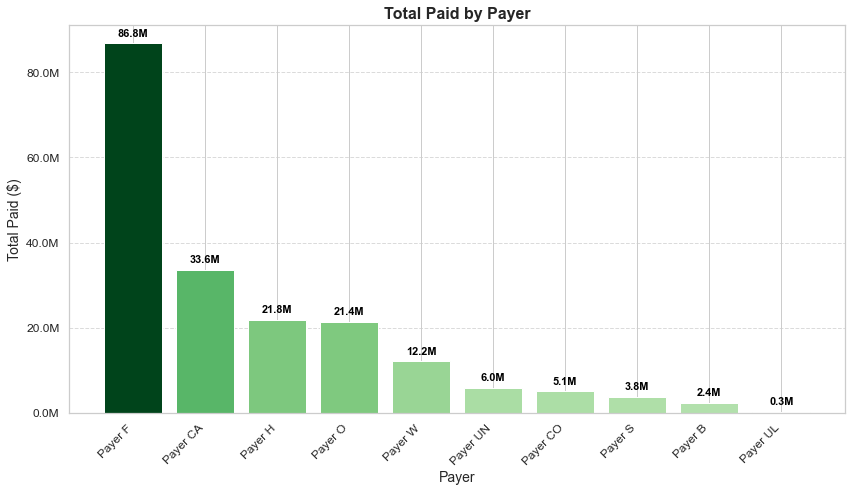

In [85]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np

# Sort the DataFrame
df_payers = df_payers.sort_values('total_paid', ascending=False)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

# Normalize total_paid for color shading
norm = plt.Normalize(df_payers['total_paid'].min(), df_payers['total_paid'].max())
cmap = plt.cm.Greens
colors = cmap(norm(df_payers['total_paid']) * 0.7 + 0.3)  # lighter green shades

bars = ax.bar(df_payers['payer'], df_payers['total_paid'], color=colors)

ax.set_xlabel('Payer', fontsize=14)
ax.set_ylabel('Total Paid ($)', fontsize=14)
ax.set_title('Total Paid by Payer', fontsize=16, weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Format y-axis ticks in millions with one decimal
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))

# Data labels in millions on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height/1e6:.1f}M',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

plt.tight_layout()
plt.show()


**Build chart with TOP 10 Claim Specialty**

In [86]:
df_specialty = df.groupby('claim_specialty')['paid_amount'].sum().reset_index()
df_specialty = df_specialty.rename(columns = {"paid_amount":"total_paid"}).sort_values(by = 'total_paid', ascending = False).head(10)
df_specialty

,claim_specialty,total_paid
314,INP,41412982
285,HOSPITAL,37810082
499,OUT,14024841
267,HEMATOLOGY/ONCOLOGY,5598740
370,MEDICAL DOCTOR,4555419
315,INTERNAL MEDICINE,4463287
784,SNF,4248390
74,CARDIOLOGY,4169214
727,RADIOLOGY,2870368
17,AMBULANCE,2408478


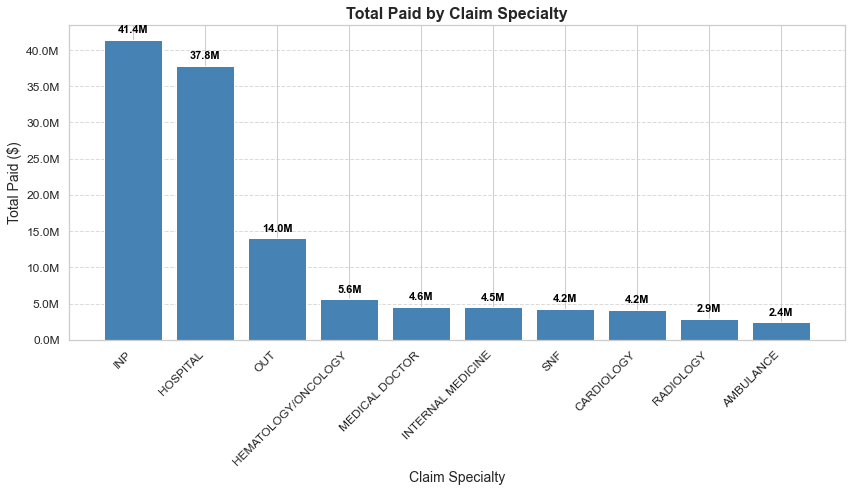

In [87]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Sort the DataFrame
df_specialty = df_specialty.sort_values('total_paid', ascending=False)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.bar(df_specialty['claim_specialty'], df_specialty['total_paid'], color='steelblue')

ax.set_xlabel('Claim Specialty', fontsize=14)
ax.set_ylabel('Total Paid ($)', fontsize=14)
ax.set_title('Total Paid by Claim Specialty', fontsize=16, weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Format y-axis ticks in millions with one decimal
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))

# Data labels in millions on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height/1e6:.1f}M',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

plt.tight_layout()
plt.show()


### ☀️ Seasonality factor

In [88]:
df.head(10)

,month,service_category,claim_specialty,payer,paid_amount,new_month_str,mm,paid_mark
0,2018-01-01,AncillaryFFS,Not Found,Payer F,4281,201801,01,bigger_zero
1,2018-01-01,AncillaryFFS,Not Found,Payer H,2221,201801,01,bigger_zero
2,2018-01-01,AncillaryFFS,Not Found,Payer O,3937,201801,01,bigger_zero
3,2018-01-01,AncillaryFFS,Not Found,Payer W,268,201801,01,bigger_zero
4,2018-01-01,AncillaryFFS,ACH,Payer W,151,201801,01,bigger_zero
5,2018-01-01,AncillaryFFS,Advanced Registered Nurse Prac,Payer UN,0,201801,01,zero
6,2018-01-01,AncillaryFFS,ADVANCED RN PRACT,Payer CA,443,201801,01,bigger_zero
7,2018-01-01,AncillaryFFS,AMBULANCE,Payer CA,14890,201801,01,bigger_zero
8,2018-01-01,AncillaryFFS,AMBULANCE,Payer CO,1722,201801,01,bigger_zero
9,2018-01-01,AncillaryFFS,AMBULANCE,Payer F,36108,201801,01,bigger_zero


In [89]:
# amount of the claims with paid mark breakdown SUM
df_season = (df.pivot_table(index = 'month', 
                                  values = 'paid_amount', 
                                  aggfunc = 'sum')
                                .reset_index()
                                  .rename(columns={"paid_amount":"total_paid"})
                   )
df_season

,month,total_paid
0,2018-01-01,6959445
1,2018-02-01,6430877
2,2018-03-01,6436167
3,2018-04-01,6748037
4,2018-05-01,6937332
5,2018-06-01,5888847
6,2018-07-01,5874723
7,2018-08-01,6268040
8,2018-09-01,5818710
9,2018-10-01,7103820


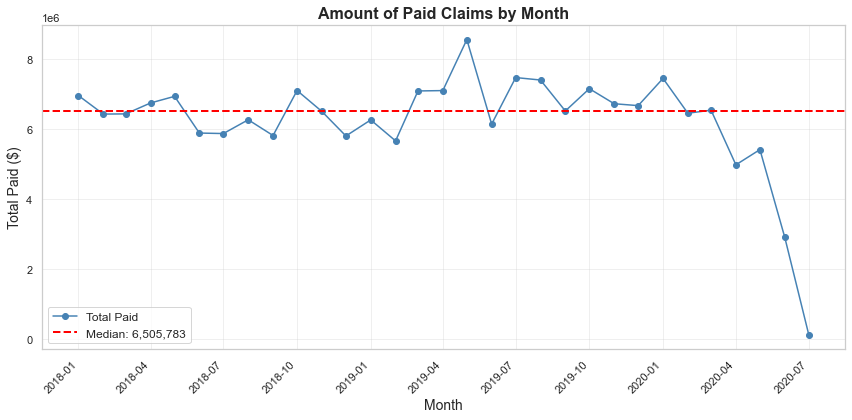

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

x = df_season['month']
y1 = df_season['total_paid']

plt.plot(x, y1, marker='o', linestyle='-', color='steelblue', label='Total Paid')

# Median line
median_value = df_season['total_paid'].median()
plt.axhline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:,.0f}')

# Titles and labels
plt.title('Amount of Paid Claims by Month', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Paid ($)', fontsize=14)

# Rotate x labels if months are long strings (optional)
plt.xticks(rotation=45, ha='right')

plt.legend(loc='lower left', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**we observe a drop since april 2020, let's dive deeper with categories and payers to find reason of drop**

In [91]:
# by provided services
df_season_serivce = (df.pivot_table(index = 'month', 
                                    columns = 'service_category',
                                  values = 'paid_amount', 
                                  aggfunc = 'sum')
                                .reset_index()
                                  .rename(columns={"paid_amount":"total_paid"})
                   )
df_season_serivce

service_category,month,ASCServices,AncillaryFFS,ERServices,InpatientServices,OutpatientServices,PCPEncounter,PCPFFS,SNFServices,SpecialistFFS,SpecialistsFFS
0,2018-01-01,172766.0,592179.0,403508.0,3737819.0,692106.0,-1149.0,159549.0,224193.0,54418.0,924056.0
1,2018-02-01,161034.0,548103.0,349886.0,3284944.0,754092.0,-128.0,132686.0,286726.0,46776.0,866758.0
2,2018-03-01,215043.0,531125.0,497605.0,2779413.0,943864.0,-9.0,131886.0,289443.0,49312.0,998485.0
3,2018-04-01,161645.0,608597.0,401902.0,3375805.0,682983.0,-3461.0,145760.0,239343.0,58815.0,1076648.0
4,2018-05-01,187127.0,666778.0,390899.0,3441408.0,719934.0,-1977.0,127545.0,300773.0,52847.0,1051998.0
5,2018-06-01,165436.0,589919.0,397435.0,2625726.0,641408.0,-1382.0,116811.0,319570.0,49484.0,984440.0
6,2018-07-01,166581.0,533844.0,430957.0,2376395.0,715961.0,-1792.0,149524.0,335171.0,58267.0,1109815.0
7,2018-08-01,206893.0,560794.0,391452.0,2731600.0,688849.0,-378.0,147742.0,272525.0,64892.0,1203671.0
8,2018-09-01,153926.0,557663.0,408991.0,2371076.0,905469.0,-1407.0,137387.0,198274.0,71114.0,1016217.0
9,2018-10-01,189917.0,599663.0,344622.0,3284682.0,715995.0,-5043.0,173264.0,302899.0,75273.0,1422548.0


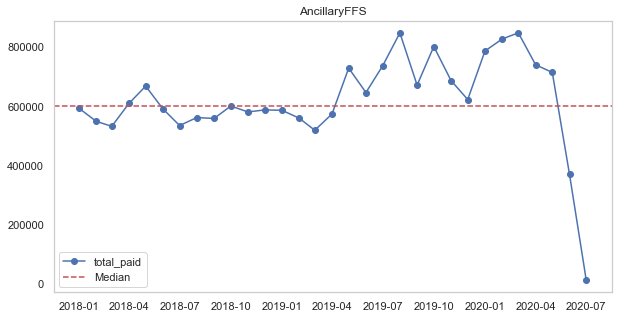

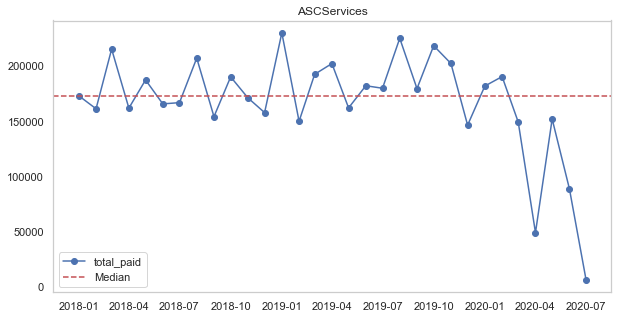

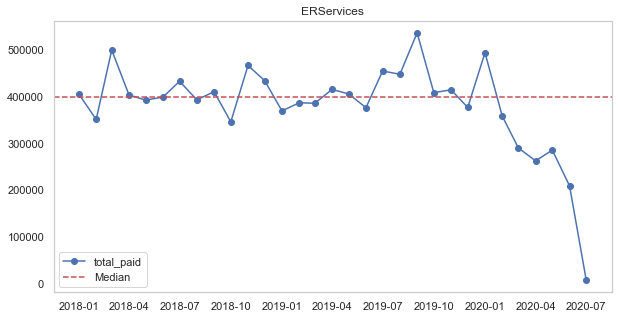

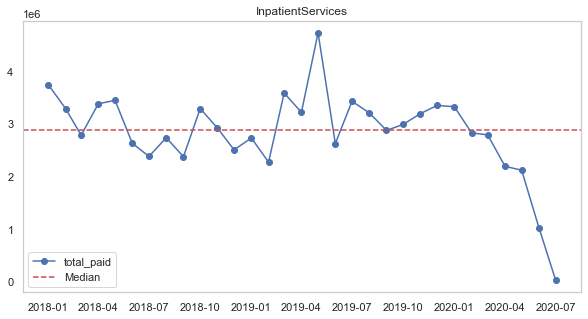

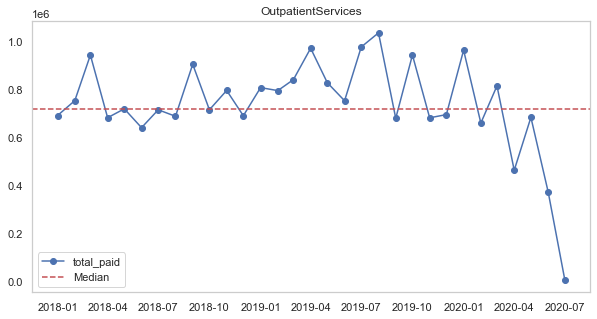

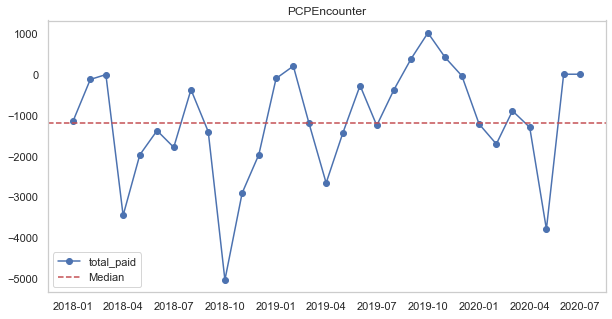

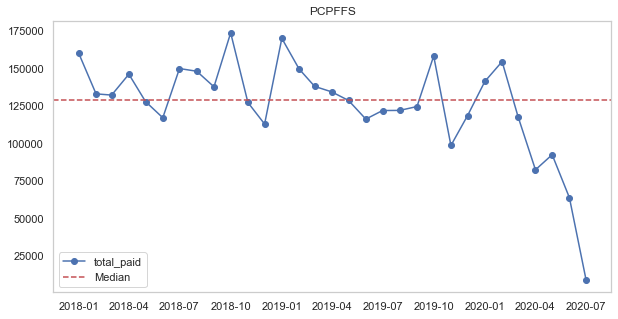

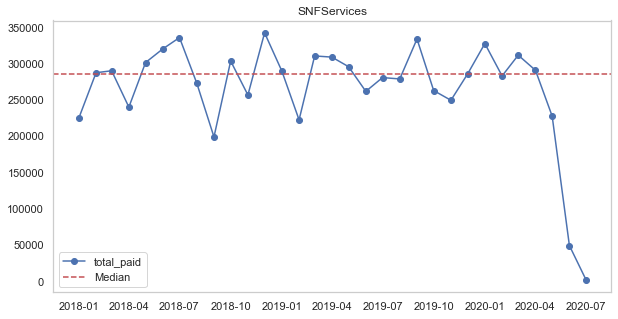

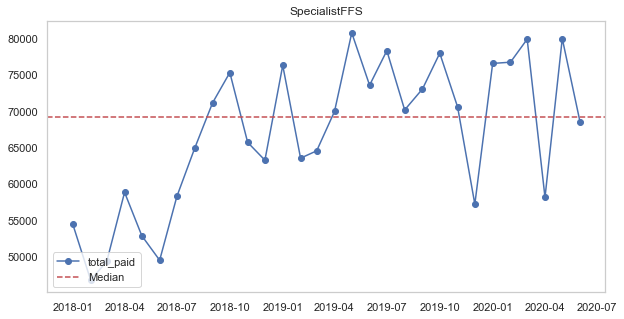

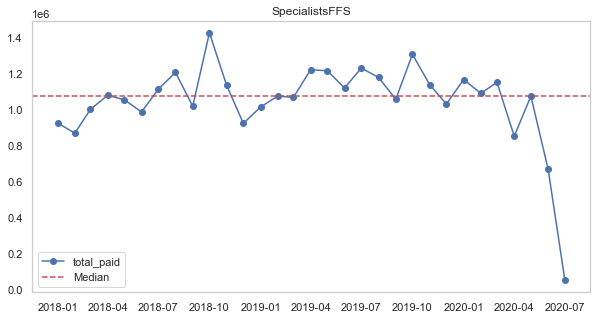

In [92]:
for i in df['service_category'].unique():
    plt.figure(figsize=(10,5))
    x = df_season_serivce['month']
    y1 = df_season_serivce[i]

    plt.title(i)
    plt.plot(x, y1, marker='o', label = 'total_paid')

    # Calculate the median of 'total_paid'
    median_value = df_season_serivce[i].median()
    plt.axhline(median_value, color='r', linestyle='--', label='Median')

    plt.legend(loc = 'lower left')
    plt.grid()
    plt.show()

In [93]:
# by provided payers
df_season_payers = (df.pivot_table(index = 'month', 
                                    columns = 'payer',
                                  values = 'paid_amount', 
                                  aggfunc = 'sum').fillna(0)
                                .reset_index()
                                  .rename(columns={"paid_amount":"total_paid"}
                                         )
                   )
df_season_payers

payer,month,Payer B,Payer CA,Payer CO,Payer F,Payer H,Payer O,Payer S,Payer UL,Payer UN,Payer W
0,2018-01-01,55252.0,948156.0,151578.0,3707987.0,662034.0,756743.0,161631.0,0.0,132192.0,383872.0
1,2018-02-01,57779.0,920544.0,168205.0,3191517.0,457856.0,934179.0,160211.0,0.0,146355.0,394231.0
2,2018-03-01,50353.0,1251597.0,175645.0,2817408.0,594198.0,771667.0,166517.0,0.0,187247.0,421535.0
3,2018-04-01,54043.0,1159421.0,169775.0,3069467.0,624561.0,973059.0,166586.0,0.0,120975.0,410150.0
4,2018-05-01,68888.0,1166791.0,165777.0,3333757.0,593914.0,842361.0,215460.0,0.0,137475.0,412909.0
5,2018-06-01,78624.0,1290040.0,123390.0,2201010.0,573987.0,802564.0,115411.0,0.0,182565.0,521256.0
6,2018-07-01,59698.0,968397.0,160199.0,2508178.0,701179.0,824852.0,120419.0,0.0,153868.0,377933.0
7,2018-08-01,85826.0,1302049.0,200600.0,2565724.0,515295.0,824171.0,189108.0,0.0,172435.0,412832.0
8,2018-09-01,104074.0,852517.0,197625.0,2614653.0,572410.0,764464.0,238795.0,0.0,120564.0,353608.0
9,2018-10-01,74512.0,1059931.0,177561.0,3852651.0,515040.0,761234.0,139302.0,0.0,151502.0,372087.0


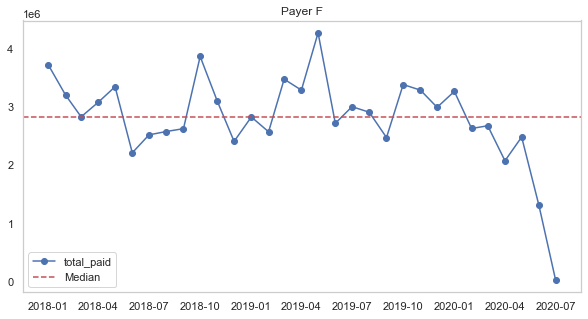

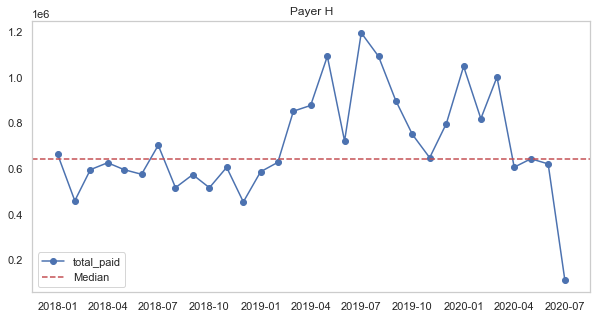

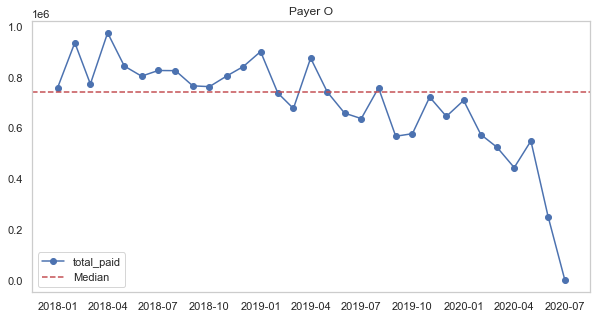

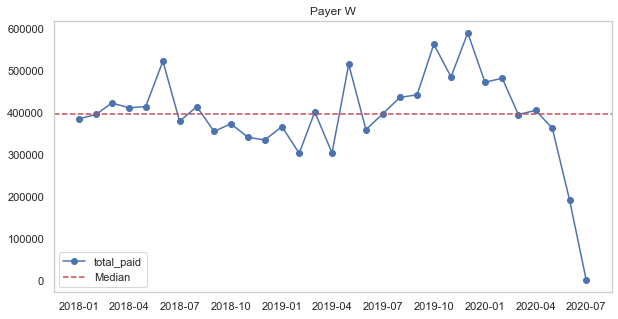

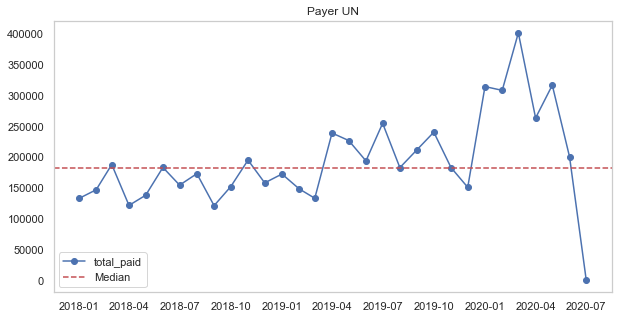

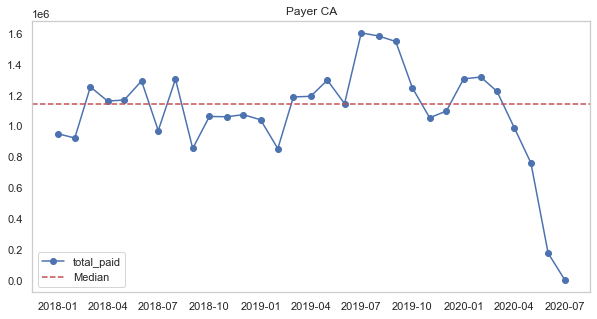

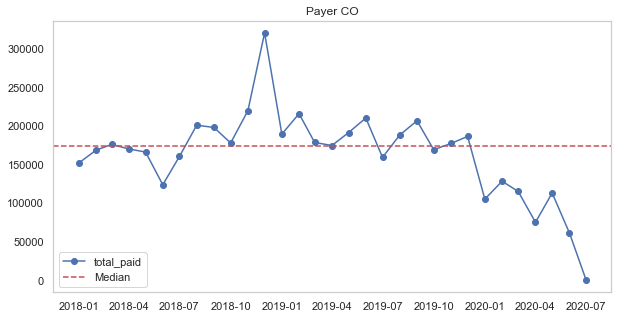

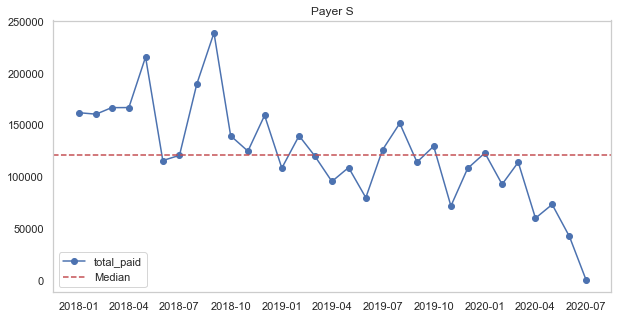

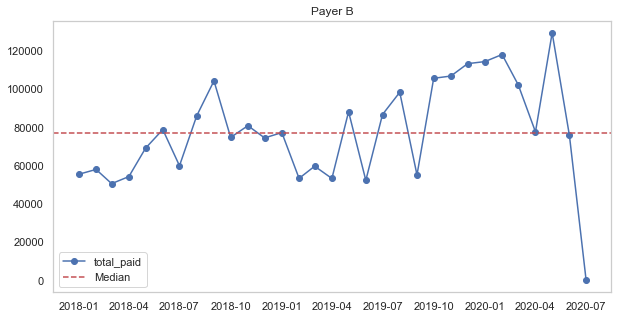

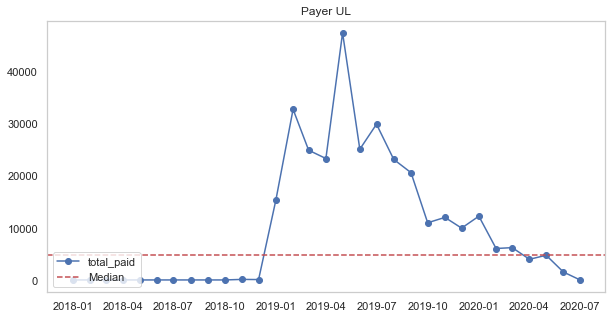

In [94]:
for i in df['payer'].unique():
    plt.figure(figsize=(10,5))
    x = df_season_payers['month']
    y1 = df_season_payers[i]

    plt.title(i)
    plt.plot(x, y1, marker='o', label = 'total_paid')

    # Calculate the median of 'total_paid'
    median_value = df_season_payers[i].median()
    plt.axhline(median_value, color='r', linestyle='--', label='Median')

    plt.legend(loc = 'lower left')
    plt.grid()
    plt.show()

we can observe situation that after Jan 2020 there is a huge drop with claims, it may be connected with COVID-19 pandemic, but I would check it once again with a another source

### 📈 Average paid amounts

In [95]:
df_avg = df.pivot_table(index='service_category',
                        values='paid_amount',
                        aggfunc=['sum', 'median', 'mean', lambda x: x.quantile(0.95), 'max'])
df_avg.columns = ['sum_paid_amount', 'median_paid_amount', 'mean_paid_amount', '95th_percentile_paid_amount', 'max_paid_amount']
df_avg = df_avg.reset_index()

df_avg

,service_category,sum_paid_amount,median_paid_amount,mean_paid_amount,95th_percentile_paid_amount,max_paid_amount
0,ASCServices,5192434,758.0,1964.598562,7971.20,65924
1,AncillaryFFS,19212602,458.0,1981.702114,8122.90,121730
2,ERServices,11773165,393.0,3186.242219,12028.80,224574
3,InpatientServices,87861676,795.0,9325.161961,11468.50,2268611
4,OutpatientServices,22935845,539.0,3025.437937,4326.00,474959
5,PCPEncounter,-35888,0.0,-29.368249,0.00,1671
6,PCPFFS,3897810,737.0,2778.196721,15477.90,54798
7,SNFServices,8226348,463.0,3290.539200,10183.60,170892
8,SpecialistFFS,2005359,583.0,1190.830760,3937.40,24699
9,SpecialistsFFS,32373940,715.0,2632.883865,10067.75,216561


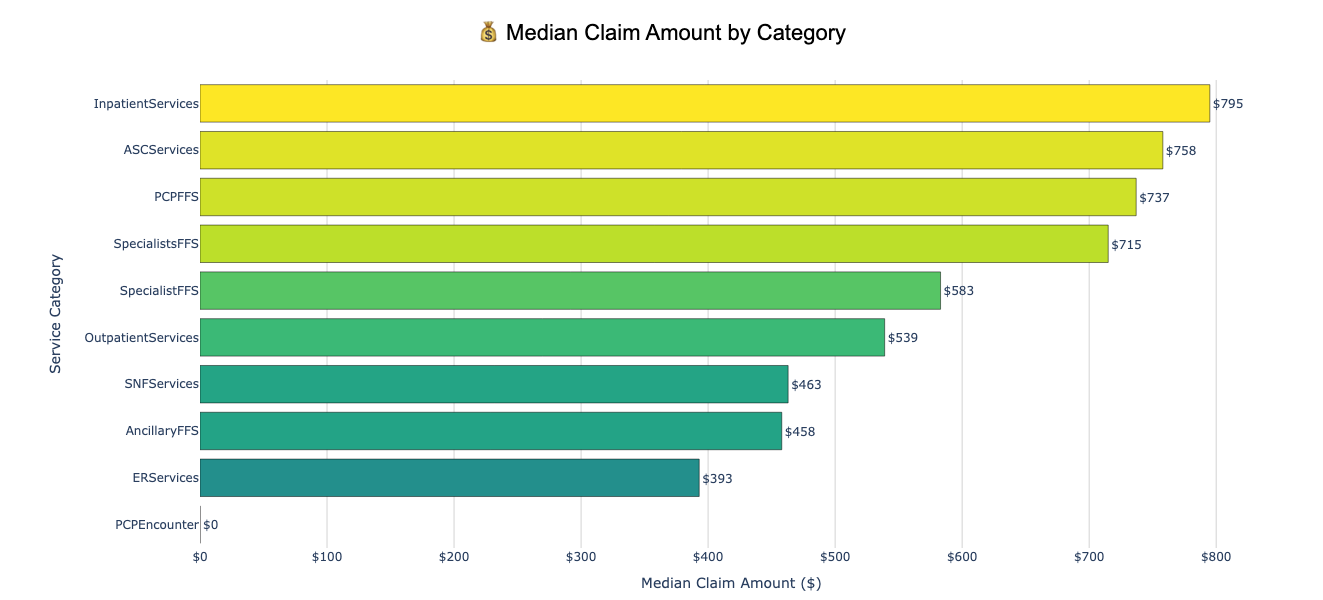

In [103]:
import plotly.graph_objects as go
import pandas as pd

# Sort data
df_avg_sorted = df_avg[['service_category', 'median_paid_amount']].sort_values(by='median_paid_amount', ascending=True)
categories = df_avg_sorted['service_category']
means = df_avg_sorted['median_paid_amount']

# Create horizontal bar chart with color scale and text labels
fig = go.Figure(data=go.Bar(
    x=means,
    y=categories,
    orientation='h',
    text=[f"${v:,.0f}" for v in means],  # Text labels
    textposition='outside',              # Outside right of bar
    marker=dict(
        color=means,
        colorscale='Viridis',
        line=dict(color='black', width=0.5)
    ),
    hovertemplate='<b>%{y}</b><br>Median Paid: %{x:$,.2f}<extra></extra>'
))

# Update layout
fig.update_layout(
    title=dict(
        text='💰 Median Claim Amount by Category',
        x=0.5,
        font=dict(size=22, family='Arial', color='black')
    ),
    xaxis=dict(
        title='Median Claim Amount ($)',
        tickprefix='$',
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        title='Service Category',
        automargin=True
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=600,
    margin=dict(l=200, r=60, t=80, b=50),  # More left margin if category names are long
    showlegend=False
)

fig.show()


In [97]:
df_avg_payer = df.pivot_table(index='payer',
                        values='paid_amount',
                        aggfunc=['sum', 'median', 'mean', lambda x: x.quantile(0.95), 'max'])
df_avg_payer.columns = ['sum_paid_amount', 'median_paid_amount', 'mean_paid_amount', '95th_percentile_paid_amount', 'max_paid_amount']
df_avg_payer = df_avg_payer.reset_index()

df_avg_payer

,payer,sum_paid_amount,median_paid_amount,mean_paid_amount,95th_percentile_paid_amount,max_paid_amount
0,Payer B,2407509,348.0,663.042963,2036.50,26574
1,Payer CA,33635443,637.0,3874.604654,9604.00,879298
2,Payer CO,5068663,607.0,1378.477835,3025.00,161285
3,Payer F,86787408,1001.0,9621.663858,26763.90,2268611
4,Payer H,21834697,1137.0,9295.315879,39464.00,621368
5,Payer O,21419407,783.5,3411.820166,8420.65,476017
6,Payer S,3810748,401.0,909.703509,2143.20,90700
7,Payer UL,310027,218.0,452.594161,1619.40,10061
8,Payer UN,5988435,343.5,917.627184,2446.50,132845
9,Payer W,12180954,518.0,1714.419986,3726.40,261963


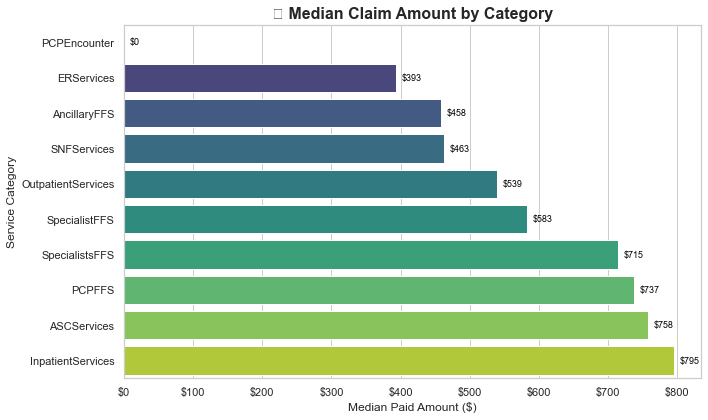

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Sort data
df_avg_sorted = df_avg[['service_category', 'median_paid_amount']].sort_values(by='median_paid_amount', ascending=True)

# Set figure and theme
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create color palette
palette = sns.color_palette("viridis", n_colors=len(df_avg_sorted))

# Create barplot
ax = sns.barplot(
    data=df_avg_sorted,
    y='service_category',
    x='median_paid_amount',
    palette=palette
)

# Add value labels at the end of each bar
for i, (value, label) in enumerate(zip(df_avg_sorted['median_paid_amount'], df_avg_sorted['service_category'])):
    ax.text(
        value + max(df_avg_sorted['median_paid_amount']) * 0.01,
        i,
        f"${value:,.0f}",
        va='center',
        ha='left',
        fontsize=9,
        color='black'
    )

# Format x-axis as currency
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Set title and labels
plt.title('💰 Median Claim Amount by Category', fontsize=16, fontweight='bold')
plt.xlabel('Median Paid Amount ($)', fontsize=12)
plt.ylabel('Service Category', fontsize=12)

plt.tight_layout()
plt.show()


**Summary:**

1. There are zero and negative counts in the data. Negative categories AncillaryFFS (2%) and PCPEncounter (7%). Zero invoices were issued for all categories, the leaders are similar categories as negative AncillaryFFS (13%) and PCPEncounter (90%).
    - Negative invoices were issued by insurance companies: Payer B, Payer CA, Payer CO, Payer H, Payer UN, Payer W. Leaders Payer UN (3.42%), Payer CA (0.96%), Payer B (0.17%)
    - Zero invoices were issued by all companies, leaders Payer UN (21.53%), Payer UL (17.96%), Payer B (11.54%) 2 out of 3 companies overlap with negative score leaders


2. We built top 10 charts:
    - by categories, InpatientServices, SpecialistsFFS, OutpatientServices became the leaders in payments
    - for insurance companies, Payer F, Payer CA, Payer H became the leaders in payments. Payer UL, Payer B, Payer S paid the least
    - by types of services provided, the leaders were INP, HOSPITAL, OUT


3. The analysis revealed a sharp decline in payments since January 2020. Perhaps the decline is due to the start of the COVID 19 pandemic, this fact needs to be further verified on the data of 2021


4. Compiled median payments by categories and insurance companies
    - by categories, InpatientServices, ASCServices, PCPFFS became the leaders in terms of the amount
    - for insurance companies by the amount of steel Payer H, Payer F, Payer O

## 🎲 Forecast

We conducted a claim EDA for insurance companies and found cases of zero and negative invoices. This issue needs to be additionally checked with business customers.

We built the distribution of data by insurance companies and service categories. Revealed the most demanded services, as well as leaders in payments among insurance companies

It is rather difficult to make a prediction for the next 6 months from the available data, since the sharp drop in payments at the end of the study period is most likely caused by an external factor (pandemic). The black swan event that reduces all predictions to guesswork. In such a situation, the most correct solution would be to commit the change and revise plans as the situation changes.

P.S. Analyzing the situation with the pandemic retrospectively, one can also argue that any plans made at the beginning of 2020 were very different from the real state of affairs. In the medium term (1-2 years), health care spending trends tend to return and will return to average values, as the influence of the external factor decreases

## 🙇 Outcomes